In [92]:
%matplotlib inline


Training a Classifier
=====================



In [93]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].
<div class="alert alert-info"><h4>Note</h4><p>If running on Windows and you get a BrokenPipeError, try setting
    the num_worker of torch.utils.data.DataLoader() to 0.</p></div>



In [94]:
# Set up dataset and classes

transform = transforms.Compose(
    [transforms.Resize((400,400), interpolation=Image.NEAREST), 
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

data_dir = '../cub_birds_data/'

dataSet = torchvision.datasets.ImageFolder(root=data_dir+'images', transform=transform)

trainloader = torch.utils.data.DataLoader(dataSet, batch_size=4,
                                          shuffle=True, num_workers=2)

f = open(data_dir + "lists/classes.txt", "r")
classes = []
for x in f:
  classes.append(x[4:-1]) 

### Let us show some of the training images, for fun.



In [95]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


class1: 1   Laysan_Albatross


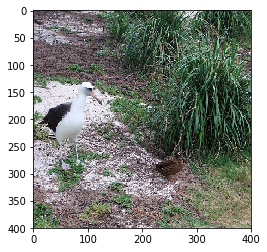

In [148]:
# Show example image with label

im1, class1 = dataSet[39]
print('class1:', class1, ' ', classes[class1])
imshow(im1)

In [97]:
# use resnet18 network and change the last layer to output 200 numbers
# for our 200 classes

net = models.resnet18()
net.fc = torch.nn.Linear(512, 200)

### 3. Define a Loss function and optimizer
Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [98]:
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 4. Train the network

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [100]:
# change this to use active learning!!!
# I'm tired, so we're just going to do proof of concept to 
# do like highest percentage wrong 
"""
flag = True
for epoch in range(2):  # loop over the dataset multiple times
    data_active = None
    labels_active = None
    per_corr_min = 1

    for i, data in enumerate(trainloader, 0):
        inputs, labels = [d.to(device) for d in data]
        
        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)
        #print('outputs:', outputs.shape)
        #print('predicted:', predicted.shape)
        
        total = labels.size(0)
        correct = (predicted == labels).sum().item()
        per_corr = correct / total

        if per_corr < per_corr_min:
            if i % 500 > 490:
                print('Percentage correct:', per_corr)
            per_corr_max = per_corr
            data_active = inputs
            labels_active = labels
    
    #running_loss = 0.0
    #for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        #inputs, labels = data.to(device)
    #inputs, labels = [d.to(device) for d in data]
    
    inputs, labels = data_active, labels_active

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # print statistics
    #running_loss += loss.item()
    #if i % 2000 == 1999:    # print every 2000 mini-batches
    #print('[%d, %5d] loss: %.3f' %
    #      (epoch + 1, i + 1, running_loss / 2000))
    #    #running_loss = 0.0

print('Finished Training')"""

"\nflag = True\nfor epoch in range(2):  # loop over the dataset multiple times\n    data_active = None\n    labels_active = None\n    per_corr_min = 1\n\n    for i, data in enumerate(trainloader, 0):\n        inputs, labels = [d.to(device) for d in data]\n        \n        outputs = net(inputs)\n        _, predicted = torch.max(outputs, 1)\n        #print('outputs:', outputs.shape)\n        #print('predicted:', predicted.shape)\n        \n        total = labels.size(0)\n        correct = (predicted == labels).sum().item()\n        per_corr = correct / total\n\n        if per_corr < per_corr_min:\n            if i % 500 > 490:\n                print('Percentage correct:', per_corr)\n            per_corr_max = per_corr\n            data_active = inputs\n            labels_active = labels\n    \n    #running_loss = 0.0\n    #for i, data in enumerate(trainloader, 0):\n        # get the inputs; data is a list of [inputs, labels]\n        #inputs, labels = data.to(device)\n    #inputs, label

In [101]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        #inputs, labels = data.to(device)
        inputs, labels = [d.to(device) for d in data]

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0


Let's quickly save our trained model:



In [102]:
PATH = './cub_birds_net.pth'
torch.save(net.state_dict(), PATH)

### 5. Test the network on the test data


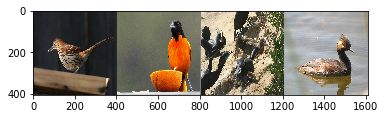

GroundTruth:  Brown_Thrasher Baltimore_Oriole Brandt_Cormorant Eared_Grebe


In [103]:
# Show example images

dataiter = iter(trainloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Next, let's load back in our saved model (note: saving and re-loading the model
wasn't necessary here, we only did it to illustrate how to do so):



In [104]:
#net = Net()
#net = models.resnet18()
#net.load_state_dict(torch.load(PATH))

Okay, now let us see what the neural network thinks these examples above are:



In [149]:
# Example outputs

outputs = net(images.to(device))
outputs.shape

print('Ground Truth Labels:')
[print(classes[label]) for label in labels]
print('\nOutput Labels:')
[print(classes[list(out).index(max(out))]) for out in outputs]

images_gpu = images.to(device)
net(images_gpu).shape

Ground Truth Labels:
American_Crow
Horned_Puffin
Clark_Nutcracker
American_Redstart

Output Labels:
Brown_Creeper
Horned_Puffin
Brown_Pelican
Yellow_billed_Cuckoo


torch.Size([4, 200])

### Outputs
The outputs are energies for the 200 classes.
The higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy. 
Let us look at how the network performs on the whole dataset.



In [151]:
correct = 0
total = 0
with torch.no_grad():
    # dataiter = iter(trainloader)
    for data in trainloader:
        images, labels = [d.to(device) for d in data] # data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the %d test images: %d %%' % (len(trainloader),  
    100 * correct / total))

Accuracy of the network on the 1509 test images: 3 %


That looks way better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [147]:
class_correct = list(0. for i in range(200))
class_total = list(0. for i in range(200))

count = 0
with torch.no_grad():
    for data in trainloader:
        count += 1
        if count == len(trainloader):
            break
        images, labels = [d.to(device) for d in data] # data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            #print('label', label.item(), label)
            #print('c[i]', c[i])
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(200):
    print('Accuracy of %5s : %4d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of Black_footed_Albatross :    0 %
Accuracy of Laysan_Albatross :    0 %
Accuracy of Sooty_Albatross :    0 %
Accuracy of Groove_billed_Ani :    0 %
Accuracy of Crested_Auklet :    0 %
Accuracy of Least_Auklet :    0 %
Accuracy of Parakeet_Auklet :    0 %
Accuracy of Rhinoceros_Auklet :    0 %
Accuracy of Brewer_Blackbird :    0 %
Accuracy of Red_winged_Blackbird :    0 %
Accuracy of Rusty_Blackbird :    0 %
Accuracy of Yellow_headed_Blackbird :    0 %
Accuracy of Bobolink :    0 %
Accuracy of Indigo_Bunting :    0 %
Accuracy of Lazuli_Bunting :    0 %
Accuracy of Painted_Bunting :    7 %
Accuracy of Cardinal :   28 %
Accuracy of Spotted_Catbird :    0 %
Accuracy of Gray_Catbird :    0 %
Accuracy of Yellow_breasted_Chat :    2 %
Accuracy of Eastern_Towhee :    0 %
Accuracy of Chuck_will_Widow :    0 %
Accuracy of Brandt_Cormorant :    0 %
Accuracy of Red_faced_Cormorant :    0 %
Accuracy of Pelagic_Cormorant :    0 %
Accuracy of Bronzed_Cowbird :    0 %
Accuracy of Shiny_Cowbi